## Replication of “Efficient Approach to Solving Transient Unsaturated Flow Problems. II: Numerical Solutions”  
Based on:
Cavalcante, A. L. B., & Zornberg, J. G. (2017). *Efficient Approach to Solving Transient Unsaturated Flow Problems. II: Numerical Solutions.* *International Journal of Geomechanics*, 17(9), 04017014.  
[https://doi.org/10.1061/(ASCE)GM.1943-5622.0000876]

**Authors of Original Paper:**  
Ph.D. André Luís Brasil Cavalcante (University of Brasília)  
Ph.D. Jorge Gabriel Zornberg (University of Texas at Austin)  

**Replication & Implementation:** Paula Sarmiento  
**Institution:** North Carolina State University
**Date:** October 2025  

This repository implements the numerical procedure proposed by Cavalcante & Zornberg (2017) for solving the so-called *Case II: Finite Column and Imposed Constant Moisture to Upper Boundary.*  
The code serves as a validation and extension for further analysis of coupled moisture–flow dynamics under varying boundary conditions and aeolian erosion in sands.



In [2]:
using Plots
using SpecialFunctions
using DelimitedFiles
using CSV
using DataFrames
using SparseArrays

## 1D Richards' Equation Derivation

For one-dimensional vertical flow in unsaturated porous media, mass conservation yields:
$$
\frac{\partial \theta}{\partial t} = -\frac{\partial v_z}{\partial z},
$$
where $\theta$ is the volumetric water content and $v_z$ is the vertical discharge velocity.

According to Darcy-Buckingham's law, the vertical flux is given by:
$$
v_z = -\frac{k_z(\psi)}{g}\left(\frac{1}{\rho_w}\frac{\partial \psi}{\partial z} - g\right),
$$
with $k_z(\psi)$ denoting the hydraulic conductivity, $\psi$ the soil suction, $\rho_w$ the water density, and $g$ the gravitational acceleration.

Substituting this flux into the mass balance yields:
$$
\frac{\partial \theta}{\partial t} 
= \frac{\partial}{\partial z}\Bigl[\frac{k_z(\psi)}{g\rho_w}\frac{\partial \psi}{\partial z} - k_z(\psi)\Bigr]
$$

Since $\psi$ and $\theta$ are related via the soil water retention curve (SWRC), we have:
$$
\frac{\partial \psi}{\partial z} 
= \frac{\partial \psi}{\partial \theta}\frac{\partial \theta}{\partial z},
$$
so that:
$$
\frac{\partial \theta}{\partial t} 
= \frac{\partial}{\partial z}\Bigl[\frac{k_z(\theta)}{g\rho_w}\frac{\partial \psi}{\partial \theta}\frac{\partial \theta}{\partial z} - k_z(\theta)\Bigr]
$$

Defining the effective diffusivity and the advective term as:
$$
D_z(\theta) = \frac{k_z(\theta)}{g\rho_w}\frac{\partial \psi}{\partial \theta}, \quad
a_s(\theta) = \frac{\partial k_z(\theta)}{\partial \theta},
$$
the final form of Richards' equation becomes:
$$
\frac{\partial \theta}{\partial t} 
= \frac{\partial}{\partial z}\Bigl[D_z(\theta)\,\frac{\partial \theta}{\partial z}\Bigr] 
- a_s(\theta)\,\frac{\partial \theta}{\partial z}
$$

## Analytical Solution - Functions

In [4]:
#ALL ANALYTICAL SOLUTIONS - CAVALCANTE (2017)

#Constante volumetric water contet condition at the top surface

#ONLY DIFFUSION - solution anylitical-cavalcante
function theta_diff(z, t, θi, θo, L, D_z)
    """
    Computes the analytical solution θ(z, t) with as=0 (No advection).
    Parameters:
    - z: Position (m).
    - t: Time (s).
    - θi: Initial water content.
    - θo: Boundary water content.
    - L: Characteristic length (m).
    - D_z: Hydraulic parameter (m²/s).
    Returns:
    - θ(z, t): Water content at position z and time t.
    """
    term1 = erfc.(z./(2*sqrt(D_z*t)))
    term2 = erfc.((2*L.-z)./(2*sqrt(D_z*t)))
    return θi.+(θo-θi).*(term1.+term2)
end

# ONLY ADVECTION - function only (Dz=0)
function heaviside(x)
    """
    Heaviside step function.
    Parameters:
    - x: Input value or array.
    Returns:
    - 0 if x <= 0, 1 if x > 0.
    """
    return x .>0
end

function theta_adv(z, t, θi, θo, a_s)
    """
    Computes θ(z, t) for the special case where D_z = 0.
    Parameters:
    - z: Position (m).
    - t: Time (s).
    - θi: Initial water content.
    - θo: Boundary water content.
    - a_s: Wavefront speed (m/s).
    Returns:
    - θ(z, t): Water content at position z and time t.
    """
    return θi.+(θo-θi).*heaviside.(a_s*t.-z)
end


# ADVECTION+DIFUSION - (Analytical-Cavalcante) with constant volumetric water content 
function B(z,t,L,D_z,a_s)
    """
    Computes B(z, t) based on the analytical formula.
    Parameters:
    - z: Position (m).
    - t: Time (s).
    - L: Characteristic length (m).
    - D_z: Hydraulic parameter (m²/s).
    - a_s: Wavefront speed (1/s).
    Returns:
    - B(z, t): Analytical solution for B(z, t).
    """
    Z_minus =(z.-a_s*t)./(2*sqrt(D_z*t))
    Z_plus =(z.+a_s*t)./(2*sqrt(D_z*t))

    term1 = 0.5.*erfc.(Z_minus)
    term2 = 0.5.*exp.((a_s.*z)./D_z).*erfc.(Z_plus)

    term3 = (0.5.*(2.0.+(a_s.*(2*L.-z))./D_z.+(a_s^2 * t)/D_z).*exp.((a_s*L)/D_z).*erfc.((2*L.-z.+a_s*t)./(2*sqrt(D_z*t))))

    term4 = (-sqrt(a_s^2*t/(π*D_z)).* exp.((a_s*L)/D_z.-((2*L.-z.+a_s*t).^2)./(4*D_z*t)))

    return term1.+term2.+term3.+term4
end

# Function to calculate θ(z, t)
function theta(z, t, θi, θo, L, D_z, a_s)
    """
    Computes θ(z, t) using B(z, t).
    Parameters:
    - z: Position (m).
    - t: Time (s).
    - θi: Initial water content.
    - θo: Boundary water content.
    - L: Characteristic length (m).
    - D_z: Hydraulic parameter (m²/s).
    - a_s: Wavefront speed (1/s).
    Returns:
    - θ(z, t): Analytical solution for θ(z, t).
    """
    B_value = B(z, t, L, D_z, a_s)
    return θi.+(θo-θi).*B_value
end

theta (generic function with 1 method)

## Soil Water Retention and Permeability Models

### Soil Water Retention Curve (SWRC)

The soil water retention curve relates the volumetric water content to matric suction. Following Cavalcante and Zornberg (2017), the suction is modeled as:
$$
\psi(\theta) = \frac{1}{\delta}\,\ln\!\Biggl(\frac{\theta - \theta_r}{\theta_s - \theta_r}\Biggr),
$$
where $\delta$ is a fitting parameter, $\theta_s$ is the saturated water content, and $\theta_r$ is the residual water content. The corresponding moisture capacity is:
$$
C(\theta) = \frac{\partial \psi}{\partial \theta} 
= \frac{1}{\delta(\theta - \theta_r)}
$$

### Permeability Model

The effective vertical permeability is given by:
$$
k_z(\theta) = k_s\,\Bigl(\frac{\theta - \theta_r}{\theta_s - \theta_r}\Bigr),
$$
where $k_s$ is the saturated permeability.

In [6]:
#SOIL MODEL FUNCTIONS

function CandM_SWRC_model(δ, θ, θr, θs) 
    """
    Calculate the matric suction (Calvalcante's hydraulic model, 2017)
    Parameters:
    - δ: Fitting hydarulic parameter.
    - θ: volumetric water content
    - θr: residual volumetric water content
    - θs: volumetric water content at saturation
    Returns: 
    - Soil Matric suction at θ.
    """
    if θ>=θs
        ψ =0
    else 
        ψ =(1.0./δ).*log.((θ.-θr)./(θs.-θr))
    end
    return ψ
end

function Inv_CandM_SWRC_model(δ, ψ, θr, θs)
    """
    Calculate the volumetric water content
    Parameters:
    - δ: Fitting hydarulic parameter.
    - ψ: matric suction
    - θr: residual volumetric water content
    - θs: volumetric water content at saturation
    Returns:
    - Volumetric water content as a function of ψ
    """
    if ψ >= 0
        θ = θr.+(θs.-θr).*exp.(-δ.*ψ)
    else
        θ = θs
    end   
    return θ
end

function CandM_moisture_capacity(δ, θ, θr,θs)
    """
    Calculate the moisture capacity function
    Parameters:
    - δ: Fitting hydarulic parameter.
    - θ: volumetric water content
    - θr: residual volumetric water content
    - θs: saturated volumetric water content
    - Calculate the moisture capacity
    """
    if θ >= θs
        C = 1/(δ.*(θs.-θr)) 
    else
        C= 1/(δ.*(θ.-θr))    
    end
    return C
end


function Permeability_Calvacante(θ, θs, θr, Ks)
    """
    Calculate the hydraulic conductivity 
    Parameters:
    # θ: volumetric water content
    # θs: volumetric water content at saturation
    # θr: residual volumetric water content
    # Ks: saturated hydraulic conductivity
    # Calculate the hydraulic conductivity
    """
    if θ>= θs 
        K = Ks
    else 
        K = Ks.*((θ.-θr)./(θs.-θr))
    end
    return K
end

#DIFFUSION AND ADVECTION FUNCTIONS (CAVALCANTE,2017)
#From using Calvancate's unsaturated hydraulic relationships, the following hydarulic parameters were obtained

#Diffusion hydraulic parameter
function D_z(ks, δ, θr, θs, ρw, g)
    """
    Calculates the diffusion hydraulic parameter D_z (Cavalcante) (m²/s)
    Parameters:
    - ks: Saturated hydraulic conductivity (m/s).
    - δ: Fitting hydarulic parameter (kPa^-1).
    - θs: Saturated volumetric water content.
    - θr: Residual volumetric water content.
    - rho_w: Water density (kg/m³).
    - g: Gravitational acceleration (m/s²).

    Returns:
    - D_z: diffusion hydraulic parameter (1/s).
    """
    return ks / (δ * (θs - θr) * ρw * g)
end



#Advection hydraulic parameter
function a_s(ks, θr, θs)
    """
    Calculates the advection hydraulic parameter a_s (Cavalcante) 
    Parameters:
    - ks: Saturated hydraulic conductivity (m/s).
    - θs: Saturated volumetric water content.
    - θr: Residual volumetric water content.
    Returns:
    - a_s: advection hydraulic parameter (1/s).
    """
    return ks / (θs-θr)
end

a_s (generic function with 1 method)

## Numerical Simulation

The numerical scheme, based on Cavalcante and Zornberg (2017), employs a time-splitting method to separate diffusion and advection. The governing equation is decomposed as:
$$
\frac{\partial \theta}{\partial t} 
= \frac{\theta_k^{n+1} - \theta_k^{(n+1)^*}}{\Delta t} 
+ \frac{\theta_k^{(n+1)^*} - \theta_k^n}{\Delta t},
$$
where $\theta_k^{(n+1)^*}$ is the intermediate solution after the diffusive step.

The diffusive step is approximated by:
$$
\frac{\theta_k^{(n+1)^*} - \theta_k^n}{\Delta t} 
= \frac{\partial}{\partial z}\!\Bigl[D_z(\theta)\,\frac{\partial \theta}{\partial z}\Bigr],
$$
and the advective step by:
$$
\frac{\theta_k^{n+1} - \theta_k^{(n+1)^*}}{\Delta t} 
= -a_s(\theta)\,\frac{\partial \theta}{\partial z}
$$


### Soil Parameters

In [7]:
# Soil parameters
Ks=8.2e-7  # (m/s) Saturated hydraulic conductivity
δ=0.03 # (kPa-1) coefficient related to AEV
θs=0.41   # Saturated volumetric water content
θr=0.04  # Residual volumetric water content
ρw=1000  # (kg/m³) Water density
g = 9.81  # (m/s²) Gravitational acceleration


# Initial parameters
θi = 0.13  # Initial water content
θo = 0.26  # Final water content


#Diffusion and advection hydraulic parameters 
Dz = D_z(Ks, δ, θr, θs,  ρw, g)
as = a_s(Ks, θr, θs)


#Spatial domain for analytical and numerical solution
N=2000 #Number of nodes of the domain (depth)
z_min=0 #m 
z_max=2 #m
z = range(z_min, z_max, length=N)  # Length of the domain


#Numerical Solution parameters and vectors
Δz= round((z_max-z_min)/(N-1), digits=10) #depth interval


# Initialization of the variables
θ_vector = ones(N) * (θi) # Initial volumetric water content
dθ_dt = zeros(N)
dθ_dz=zeros(N) #dθ_vector


# dθ_dz at t=0
for i=2:N-1
    if abs(θ_vector[i+1]-θ_vector[i])<abs(θ_vector[i]-θ_vector[i-1])
        dθ_dz[i]=(θ_vector[i+1]-θ_vector[i])/Δz
    else
        dθ_dz[i]=(θ_vector[i]-θ_vector[i-1])/Δz
    end
end


#For the numerical solution, this vectors are the intermediate step betweeen the diffusion component and advection component
θ_vector_inter = zeros(N) 
dθ_dz_inter = zeros(N) 

#Dummy variable to save the data for each step
θ_vector_nplus1 = zeros(N)  
dθ_dz_nplus1 = zeros(N)

#coefficients for the CIP method
a_vector=zeros(N)  
b_vector=zeros(N)  
d_vector=zeros(N)  
e_vector=zeros(N)  

# Initialization of hydraulic parameters
k_vector = zeros(N)
Dz_vector= zeros(N)

for i = 1:N
    k_vector[i] = Permeability_Calvacante(θ_vector[i], θs, θr, Ks)
    Dz_vector[i]=k_vector[i]*CandM_moisture_capacity(δ, θ_vector[i], θr,θs)/(ρw*g)
end


# Time parameters
Ne=0.45 #Neumann number <=0.5
Cr=1    #Courant number <=1
ΔtmaxD=(Δz^2)*Ne/Dz
ΔtmaxA=(Δz*Cr/as)
Δt = min(ΔtmaxD,ΔtmaxA)  # Time step


#Time set up
times = [300*60,600*60]
t_max =maximum(times)
n_steps = round(Int, t_max / Δt)  # Number of time steps

θ_tensor=zeros(N, Int(n_steps), length(times))

2000×602×2 Array{Float64, 3}:
[:, :, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 ⋮                        ⋮              ⋱  ⋮                        ⋮    
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0 

## Boundary and Initial Conditions

We consider a finite soil column spanning \(z=0\) to \(z=L\) with the initial condition:
$$
\theta(z,0) = \theta_i, \quad 0 \le z \le L,
$$
where $\theta_i$ is the uniform initial water content.

At the upper boundary $z=0$, a constant volumetric water content is imposed:
$$
\theta(0,t) = \theta_0
$$

At the lower boundary $z=L$, an impermeable (no-flux) condition is enforced:
$$
\left.\frac{\partial \theta}{\partial z}\right|_{z=L} = 0 \quad \text{or} \quad v_z(L,t) = 0.
$$
---

At the upper boundary (node $k=1$), the imposed volumetric water content is enforced by:
$$
\theta_{1} = \theta_{0}
$$
Iterations continue until the solution converges.

At the lower boundary $z=L$, the impermeable condition is discretely implemented as:
$$
\theta_N = \theta_{N-1},
$$
where node $N$ corresponds to $z=L$.

## Non-Advective (Diffusion)

### Diffusion Component

The diffusion term is given by:
$$
\frac{\partial \theta}{\partial t} 
= \frac{\partial}{\partial z}\!\Bigl[D_z(\theta)\,\frac{\partial \theta}{\partial z}\Bigr],
$$
and is discretized on a uniform grid as:
$$
\frac{\theta_k^{n+1} - \theta_k^n}{\Delta t} 
= D_z(\theta_k^n)\,\frac{\theta_{k+1}^n - 2\,\theta_k^n + \theta_{k-1}^n}{(\Delta z)^2}.
$$

In [8]:
#Non-Advective Anylitical
θ_diff_analytical = [theta_diff(z, t, θi, θo, z_max, Dz) for t in times]

2-element Vector{Vector{Float64}}:
 [0.26, 0.2537010054584592, 0.24742521937712486, 0.2411955939986073, 0.23503457383887294, 0.22896385347429876, 0.22300414897439166, 0.21717498698256366, 0.211494515002351, 0.2059793359180334  …  0.13, 0.13, 0.13, 0.13, 0.13, 0.13, 0.13, 0.13, 0.13, 0.13]
 [0.26, 0.2555445680213963, 0.25109735283426654, 0.24666652579734716, 0.24226016782232485, 0.2378862251909813, 0.23355246660613493, 0.22926644186289818, 0.2250354425060841, 0.22086646481438596  …  0.13, 0.13, 0.13, 0.13, 0.13, 0.13, 0.13, 0.13, 0.13, 0.13]

In [9]:
#Non-Advective Numerical Solution

#Storage Variables
θ_diff_numerical = zeros(N, length(times)) #Variable to save different time runs (Length, Time runs)
θ_diff_times=zeros(N, Int(n_steps), length(times)) #Variable to save the results in each time step  (Lenght, time step, time runs)

#Dummy variables to compute the parameters each step
θ_vector_i=zeros(N)
Dz_vector_i=zeros(N)
k_vector_i=zeros(N)

#Convergence parameters for boundary conditions using Newton Rapson Method
max_iter=100
tol=1e-6

#Dummy variables to check Numerical process
Ne_vector=zeros(N,n_steps) #Neumann number
v0_vector=zeros(n_steps)


for (t_idx, t) in enumerate(times)
    
    # Initialize values for t=0 (n=0)
    θ_vector_i .= θ_vector #Initial values θi
    k_vector_i=k_vector
    Dz_vector_i=Dz_vector
    n_steps = round(Int, t / Δt)

    # Time loop 
    for n = 1:n_steps
        # Boundary conditions

        #Constant volumetric water content (θo) at the surface. Solved with Newton-Rapson for upper boundary condition
        θ_vector_i[1] = θo 

        #Lower boundary condition
        θ_vector_i[N] = θ_vector_i[N-1] 

        # Update the value of dθ_dt for each point in the domain (except boundary nodes)
        for i = 2:N-1
            #dθ_dt[i] = ((Dz_vector_i[i+1]-Dz_vector_i[i-1])/(2*Δz))*((θ_vector_i[i+1] - θ_vector_i[i-1])/(2*Δz))+(Dz_vector_i[i] * (θ_vector_i[i+1] - 2 * θ_vector_i[i] + θ_vector_i[i-1]) / (Δz^2))
            dθ_dt[i] =(Dz_vector_i[i] * (θ_vector_i[i+1] - 2 * θ_vector_i[i] + θ_vector_i[i-1]) / (Δz^2))
        end

        # Update the θ vector for the next n
        θ_vector_nplus1 .=  dθ_dt .* Δt .+ θ_vector_i
        
        # Update the permeability vector
        k_vector_i.= Permeability_Calvacante.(θ_vector_nplus1, θs, θr, Ks)
        Dz_vector_i.=k_vector.*CandM_moisture_capacity.(δ, θ_vector_nplus1, θr,θs)/(ρw*g)
        Ne_vector.=Dz_vector_i.*Δt /Δz^2


        # Update the θ vector 
        θ_vector_i .= θ_vector_nplus1
        θ_diff_times[:,n,t_idx].=θ_vector_i
    end

    # Water content result for the current time 't'
    θ_diff_numerical[:, t_idx] .= θ_vector_i

end

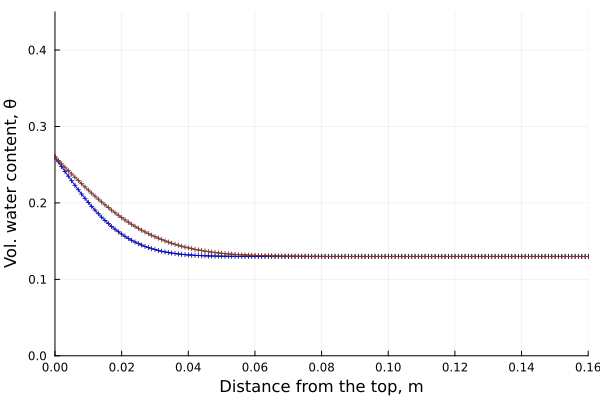

In [10]:
colors = [:blue, :brown, :orange, :green, :purple]  # Custom colors
colors_numerical = [colorant"#000066", colorant"#3E2C22", colorant"#CC6A00", colorant"#003300", colorant"#2E003E"]  # Custom colors
plot(legendfontsize=6)  # Initialize the plot

for (t_idx, t) in enumerate(times)
    plot!(z, θ_diff_numerical[:, t_idx], grid=true, seriestype=:scatter,markershape=:cross,markersize=2.5, xlim=(0, 0.16),ylim=(0, 0.45), color=colors_numerical[t_idx])
    plot!(z, θ_diff_analytical[t_idx], legend=false, color=colors[t_idx] )
end

xticks = 0:0.02:0.16

xlabel!("Distance from the top, m")
ylabel!("Vol. water content, θ")
plot!(xticks=xticks)

### Advection Component

For advection, the CIP0 scheme (Yabe and Aoki, 1991) reconstructs the solution using cubic interpolation. The one-dimensional advection equation is:
$$
\frac{\partial \theta}{\partial t} + a_s(\theta)\,\frac{\partial \theta}{\partial z} = 0.
$$
Within each cell $[z_k, z_{k+1}]$, the solution is approximated by a cubic polynomial:
$$
F^{(n+1)^*}_k(z) 
= a^{(n+1)^*}_k (z-z_k)^3 
+ b^{(n+1)^*}_k (z-z_k)^2 
+ \theta'^{(n+1)^*}_k\,(z-z_k) 
+ \theta^{(n+1)^*}_k,
$$
with continuity enforced at $z_{k+1}$:
$$
F^{(n+1)^*}_k(z_{k+1}) = \theta^{(n+1)^*}_{k+1},
$$
$$
F'^{(n+1)^*}_k(z_{k+1}) = \theta'^{(n+1)^*}_{k+1}.
$$
The updated solution is then obtained by shifting:
$$
\theta^{n+1}_k = F^{(n+1)^*}_k\Bigl(z_k - a_s\,\Delta t\Bigr),
$$
$$
\theta'^{n+1}_k = F'^{(n+1)^*}_k\Bigl(z_k - a_s\,\Delta t\Bigr).
$$

In [11]:
#Only Advective Analytical
θ_adv_analytical = [theta_adv(z, t, θi, θo, as) for t in times]

2-element Vector{Vector{Float64}}:
 [0.26, 0.26, 0.26, 0.26, 0.26, 0.26, 0.26, 0.26, 0.26, 0.26  …  0.13, 0.13, 0.13, 0.13, 0.13, 0.13, 0.13, 0.13, 0.13, 0.13]
 [0.26, 0.26, 0.26, 0.26, 0.26, 0.26, 0.26, 0.26, 0.26, 0.26  …  0.13, 0.13, 0.13, 0.13, 0.13, 0.13, 0.13, 0.13, 0.13, 0.13]

In [13]:
#Advective Numerical Solution

#Storage Variables
θ_adv_numerical= zeros(N, length(times)) #Variable to save different time runs (Length, Time runs)
θ_adv_times=zeros(N, Int(n_steps), length(times)) #Variable to save the results in each time step  (Lenght, time step, time runs)

#Dummy variables to compute the parameters each step
θ_vector_i=zeros(N)
q_i=zeros(N)
k_vector_i=zeros(N)
Dz_vector_i=zeros(N)

#Convergence parameters for boundary conditions using Newton Rapson Method
max_iter=100
tol=1e-6


for (t_idx, t) in enumerate(times)
    # Initialize values for t=0 (n=0)
    θ_vector_i .= θ_vector  #Initial values θi
    q_i .= dθ_dz    
    k_vector_i=k_vector
    Dz_vector_i=Dz_vector

    n_steps = Int(round((t / Δt), digits=0))
    
    # Boundary conditions
    #Constant volumetric water content (θo) at the surface. Solved with Newton-Rapson for upper boundary condition
    θ_vector_i[1] = θo 
    θ_vector_i[N] = θ_vector_i[N-1]

    # Time-stepping loop
    for n = 1:n_steps

        # Advection coefficients
        for i = 2:N
            a_vector[i] = ((q_i[i] + q_i[i-1]) / (Δz^2)) - (2 / Δz^3) * (θ_vector_i[i] - θ_vector_i[i-1])
            b_vector[i] = (-(θ_vector_i[i] - θ_vector_i[i-1]) * (3 / Δz^2)) + (1 / Δz) * (2 * q_i[i] + q_i[i-1])
            d_vector[i] = q_i[i]
            e_vector[i] = θ_vector_i[i]
        end

        # Updated θ and dθ for the next time step
        for i = 2:N-1
            θ_vector_nplus1[i] = a_vector[i] * (-as * Δt)^3 + b_vector[i] * (-as * Δt)^2 +
                                 d_vector[i] * (-as * Δt) + e_vector[i]
            dθ_dz_nplus1[i] = 3 * a_vector[i] * (-as * Δt)^2 + 2 * b_vector[i] * (-as * Δt) + d_vector[i]
        end

        
        # Update θi and q for the next step
        θ_vector_i .= θ_vector_nplus1
        θ_vector_i[N] = θ_vector[N-1]
        q_i .= dθ_dz_nplus1
        θ_adv_times[:,n,t_idx]=θ_vector_i

    end


    # Water content result for the current time 't'
    θ_adv_numerical[:, t_idx] .= θ_vector_i
end

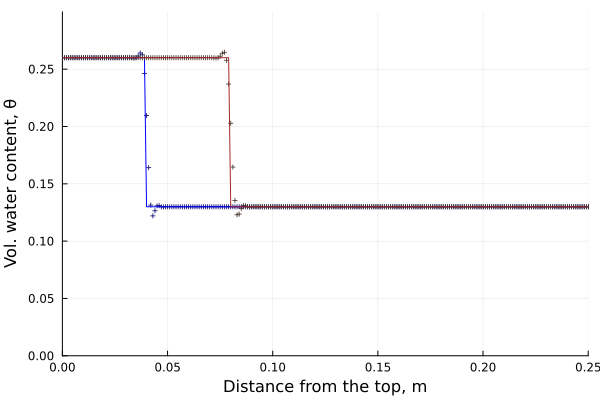

In [14]:
colors = [:blue, :brown, :orange, :green, :purple]  
colors_numerical = [colorant"#000066", colorant"#3E2C22", colorant"#CC6A00", colorant"#003300", colorant"#2E003E"]  
plot( legendfontsize=6)   

for (t_idx, t) in enumerate(times)
    plot!(z,  θ_adv_numerical[:, t_idx],  label="Numerical t = $(t / 60) min", grid=true, seriestype=:scatter,markershape=:cross,markersize=2.5,  xlim=(0, 0.25),ylim=(0, 0.3), color=colors_numerical[t_idx] )
    plot!(z,θ_adv_analytical[t_idx], legend=false, #label="Analytical t = $(t / 60) min", 
        color=colors[t_idx] )
end
xticks = 0:0.05:2
xlabel!("Distance from the top, m")
ylabel!("Vol. water content, θ")
plot!(xticks=xticks)

## Advection+Difussion

In [15]:
#Both Effects
theta_values_analytical = [theta(z, t, θi, θo, z_max, Dz, as) for t in times]

2-element Vector{Vector{Float64}}:
 [0.26, 0.259953593884542, 0.2598929572396657, 0.2598153807559863, 0.259717823245894, 0.25959689794386287, 0.25944886282231083, 0.25926961575290564, 0.2590546953420921, 0.2587992882438629  …  0.13, 0.13, 0.13, 0.13, 0.13, 0.13, 0.13, 0.13, 0.13, 0.13]
 [0.26, 0.2599989888666382, 0.25999766272725267, 0.2599959546132238, 0.2599937863509921, 0.2599910670823198, 0.259987691644648, 0.25998353880625136, 0.25997846935193736, 0.25997232401631376  …  0.13, 0.13, 0.13, 0.13, 0.13, 0.13, 0.13, 0.13, 0.13, 0.13]

In [16]:
#Storage Variables
θ_numerical = zeros(N, length(times))
dθ_dz_numerical = zeros(N, length(times))
θ_times=zeros(N, Int(n_steps), length(times)) #Variable to save the results in each time step  (Lenght, time step, time runs)

#Dummy variables to compute the parameters each step
θ_vector_i=zeros(N)
dθ_dz_i=zeros(N)
k_vector_i=zeros(N)
Dz_vector_i=zeros(N)

#Convergence parameters for boundary conditions using Newton Rapson Method
max_iter=100
tol=1e-6


for (t_idx, t) in enumerate(times)
    # Initialize values for t=0 (n=0)
    θ_vector_i .= θ_vector  
    dθ_dz_i .= dθ_dz   
    k_vector_i=k_vector
    Dz_vector_i=Dz_vector

    # Boundary conditions
    #Constant discharge v_0. Solved with Newton-Rapson for upper boundary condition
    θ_vector_i[1] = θo 
    θ_vector_i[N] = θ_vector_i[N-1]

    # Time-stepping loop
    n_steps = Int(round((t / Δt), digits=0))
    for n = 1:n_steps

        # Step 1: Diffusive term (Finite Difference)
        for i = 2:N-1  # Keep the boundary nodes out
            dθ_dt[i] = (Dz * (θ_vector_i[i+1] - 2 * θ_vector_i[i] + θ_vector_i[i-1]) / (Δz^2))
        end

        # Update θ (diffusive term) for (n+1)* 
        θ_vector_inter .= dθ_dt .* Δt .+ θ_vector_i

        # Step 2: Update dθ/dz using CIP logic
        dθ_dz_inter[2:N-1] .= (θ_vector_inter[3:N] .- θ_vector_inter[1:N-2]) / (2 * Δz)

        for i = 2:N-1
            if abs(θ_vector_inter[i+1] - θ_vector_inter[i]) < abs(θ_vector_inter[i] - θ_vector_inter[i-1])
                dθ_dz_inter[i] = (θ_vector_inter[i+1] - θ_vector_inter[i]) / Δz
            else
                dθ_dz_inter[i] = (θ_vector_inter[i] - θ_vector_inter[i-1]) / Δz
            end
        end

        # Step 3:  Advective term (CIP method)
        for i = 2:N
            a_vector[i] = ((dθ_dz_inter[i] + dθ_dz_inter[i-1]) / (Δz^2)) - (2 / Δz^3) * (θ_vector_inter[i] - θ_vector_inter[i-1])
            b_vector[i] = (-(θ_vector_inter[i] - θ_vector_inter[i-1]) * (3 / Δz^2)) + (1 / Δz) * (2 * dθ_dz_inter[i] + dθ_dz_inter[i-1])
            d_vector[i] = dθ_dz_inter[i]
            e_vector[i] = θ_vector_inter[i]
        end

        for i = 2:N-1
            θ_vector_nplus1[i] = a_vector[i] * (-as * Δt)^3 + b_vector[i] * (-as * Δt)^2 +
                                 d_vector[i] * (-as * Δt) + e_vector[i]
            dθ_dz_nplus1[i] = 3 * a_vector[i] * (-as * Δt)^2 + 2 * b_vector[i] * (-as * Δt) + d_vector[i]
        end

    # Step 4: Update θ and dθ for the next time step
       # Update θi and q for the next step
        θ_vector_i .= θ_vector_nplus1
        θ_vector_i[N] = θ_vector[N-1]
        θ_vector_i[1] = θo
        dθ_dz_i .= dθ_dz_nplus1
        θ_times[:,n,t_idx]=θ_vector_i

    end

    # Store the results for the current time step
    θ_numerical[:, t_idx] .= θ_vector_i
    dθ_dz_numerical[:, t_idx] .= dθ_dz_i
end


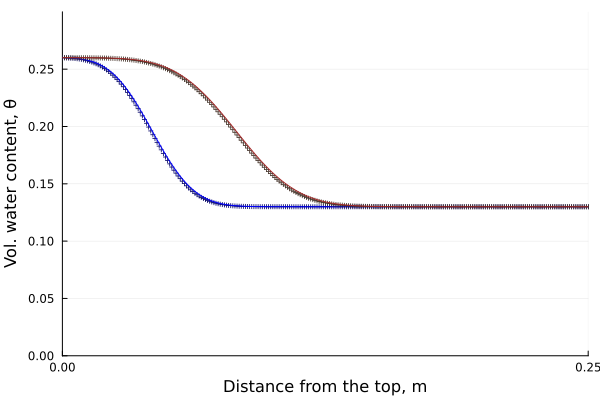

In [17]:
colors = [:blue, :brown, :orange, :green, :purple]  
colors_numerical = [colorant"#000066", colorant"#3E2C22", colorant"#CC6A00", colorant"#003300", colorant"#2E003E"]  
plot( legendfontsize=6)   

for (t_idx, t) in enumerate(times)
    plot!(z, θ_numerical[:, t_idx], label="Numerical t = $(t / 60) min", grid=true, seriestype=:scatter,markershape=:cross,markersize=2.5, xlim=(0, 0.25),ylim=(0, 0.3), color=colors_numerical[t_idx])
    plot!(z, theta_values_analytical[t_idx], legend=false,color=colors[t_idx])
end
xticks = 0:0.25:2
xlabel!("Distance from the top, m")
ylabel!("Vol. water content, θ")
plot!(xticks=xticks)